# Localization - Line Map - SMC Move

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [4]:
#nbx --fname="src/smc_move.jl"
push!(LOAD_PATH, "src");
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

Base.Vector(p::Pose) = [p.x;p.hd];

In [5]:
#nbx
include("src/unpack_data.jl")

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


glimpse_at_data (generic function with 2 methods)

In [6]:
#nbx
include("src/slam_stuff_and_utils.jl");
include("src/pose_prior_model.jl");
include("src/motion_model.jl");

In [7]:
#nbx
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    for (p,c) in zip(ps,cs)
        plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
end

function Plots.plot!(ps::Vector{Pose}; r=0.5, args...)
    for p in ps
        plot!([p.x, p.x + r*unit_vec(p.hd)];args...)
    end
end

## SMC - Move

In [8]:
#nbx
using CUDA

### logsumexp

In [9]:
#nbx
function logsumexp_cu(x, dim)
    c = maximum(x)
    return c .+ log.(sum(exp.(x .- c), dims=dim))
end

logsumexp_cu (generic function with 1 method)

### raycast

In [10]:
#nbx
include("src/cuda_raycaster_line_map.jl");

segs_ = CuArray(stack(Vector.(_segs)))

# Todo: Change cast_v4! signature and put z_ in there 
#       and replace arg by num_a and fov....
function cast_cu(ps_::CuArray; blockdims=(16,16))
    n = size(segs_, 1)    
    m = size(ps_,1)
    z_ = Inf*CUDA.ones(m, n, 360)
    z_ = cast_v4!(segs_,ps_,z_; blockdims=blockdims)
    
    return z_
end

cast_cu (generic function with 1 method)

### Pose grid

In [12]:
#nbx
"""
    ps_ = pose_grid(p, k, delta_x, delta_hd)

Returns CuArray of pose vectors (k^2, 3).
"""
function pose_grid(p, k, delta_x, delta_hd)

    dx1_ = CUDA.collect(CUDA.range(-delta_x,  delta_x, k))
    dx2_ = CUDA.collect(CUDA.range(-delta_x,  delta_x, k))
    dhd_ = CUDA.collect(CUDA.range(-delta_hd/360*π, delta_hd/360*π,k))
    dx1_ = CuArray(dx1_)
    dx2_ = CuArray(dx2_)
    dhd_ = CuArray(dhd_)
    dx1_ = CUDA.repeat(dx1_,  1, k, k)
    dx2_ = CUDA.repeat(reshape(dx2_,1,k,1), k, 1, k)
    dhd_ = CUDA.repeat(reshape(dhd_,1,1,k), k, k, 1)

    ps_ = CUDA.cat(dx1_,dx2_, dhd_, dims=4)
    ps_ = reshape(ps_, :,3)
    ps_ = ps_ .+ reshape(CuArray(Vector(p)),1,3)
    return ps_
end

pose_grid

In [13]:
p = _ps[1]
delta_x  = 0.5
delta_hd = 10
k = 10
ps_ = pose_grid(p,k,delta_x,delta_hd);
println("ps_: $(size(ps_))")
@btime pose_grid($p,$k,$delta_x,$delta_hd) samples=1 evals=1;

ps_: (1000, 3)
  279.525 μs (396 allocations: 20.44 KiB)


Runtime:
```julia
ps_: (1000, 3)
  158.146 μs (396 allocations: 20.44 KiB)
```

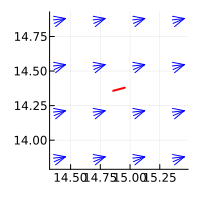

In [14]:
p        = _ps[1]
delta_x  = 0.5
delta_hd = 45
k   = 4
ps_ = pose_grid(p,k,delta_x,delta_hd);
ps  = [Pose(p[1:2],p[3]) for p in eachrow(Array(ps_))]

# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(ps, c=:blue, r=0.1, linewidth=1)
plot!(p, c=:red, r=0.1, linewidth=2)
mypl

### sliding window

In [15]:
#nbx
"""
    slw_kernel!(x, w::Int, y)

CUDA kernel to compute sliding windows...
Takes CuArrays of shape `(k,n)` and `(k,n,m=2w+1)` 
and fills the latter with ...
"""
function slw_kernel!(x, w::Int, y)
    
    m = 2*w + 1
    
    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform `1:m` to `-w:w`
        offset = j_mix-1-w
        
        # Wrap around, e.g. map `n+1` to `1`
        # Note that we have `size(x,2) == size(y,2)`
        j_mix_adj = mod(j_obs + offset - 1 , size(x,2)) + 1
        
        # Fill y's
        @inbounds y[j_pose, j_obs, j_mix] = x[j_pose, j_mix_adj]
    end
    return
end

"""
```julia
    y = slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
```
Computes sliding windows... takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, w, y)
    end
    
    return y
end;

In [16]:
w = 1
zs = stack([collect(1.0:5.0)*10^(i-1) for i=1:10])
zs_ = CuArray(zs)
zs_tilde_ = slw_cu!(zs_,w)

println(size(zs_))
println(size(zs_tilde_))

zs_tilde_[1,:,w+1] # this is the middle of the mixture window

(10, 5)
(10, 5, 3)


5-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 1.0
 2.0
 3.0
 4.0
 5.0

### y_tilde

In [17]:
#nbx
polar_inv_cu(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);

In [18]:
a_ = CuArray(range(0,π, 5))
a_tilde_ = slw_cu!(reshape(a_,1,:),w)

println(size(zs_tilde_), size(a_tilde_))
y_tilde_ = polar_inv_cu(zs_tilde_, a_tilde_)
size(y_tilde_)

(10, 5, 3)(1, 5, 3)


(10, 5, 3, 2)

In [19]:
#nbx
"""
    ys_tilde_ = get_ys_tilde_cu(zs_::CuArray, w::Int)    

Takes depth measurements and returns 
the point clouds for the gaussian mixtures ...
"""
function get_ys_tilde_cu(zs_::CuArray, w::Int)    
    a_ = CuArray(_as)

    zs_tilde_ = slw_cu!(zs_, w)
    as_tilde_ = slw_cu!(reshape(a_,1,:), w)
    
    ys_tilde_ = polar_inv_cu(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [20]:
p        = _ps[1]
grid_x  = 0.5
grid_hd = 45
grid_k   = 4
ps_ = pose_grid(p,grid_k,grid_x,grid_hd);

w = 5
zs_       = cast_cu(ps_)
ys_tilde_ = get_ys_tilde_cu(zs_, w);  
println("ys_tilde: $(size(ys_tilde_))")

@btime get_ys_tilde_cu(zs_, w) samples=1 evals=1;  

ys_tilde: (64, 360, 11, 2)
  335.861 μs (249 allocations: 13.38 KiB)


```julia
ys_tilde: (1000, 360, 11, 2)
  583.812 μs (247 allocations: 13.34 KiB)
```

### sensor_smc_logpdf_cu

In [21]:
#nbx
"""
    log_p = gaussian_logpdf(x, mu, sig)

Benchmarks in `33 - CUDA Accelerated Gen Distributions` ...
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sqrt.(sig * 2 * π)) .- 1/2 * d
    return log_p
end;

In [22]:
n = 2

x   = rand(n,n,n)
y   = rand(n,n,n)
sig = ones(n,n,n)

x_   = CuArray(x)
y_   = CuArray(y)
sig_ = CuArray(sig)

function bench_broadcasting(x,y,sig) 
    logpdf.([normal], x, y, sig)
end

println("x,y,sig: $(size(x))")

@btime bench_broadcasting($x, $y, $sig) samples=1 evals=1;
@btime gaussian_logpdf($x, $y, $sig)    samples=1 evals=1;
@btime gaussian_logpdf($x_, $y_, $sig_) samples=1 evals=1;

x,y,sig: (2, 2, 2)
  3.606 μs (2 allocations: 176 bytes)
  6.857 μs (7 allocations: 896 bytes)
  725.722 μs (238 allocations: 18.36 KiB)


Runtimes:
```julia
x,y,sig: (10, 10, 10)
   14.148 μs (2 allocations: 7.98 KiB)
   31.857 μs (7 allocations: 55.56 KiB)
  133.492 μs (226 allocations: 17.25 KiB)

x,y,sig: (100, 100, 100)
   10.390 ms (3 allocations: 7.63 MiB)
   27.895 ms (14 allocations: 53.41 MiB)
  119.987 μs (226 allocations: 17.25 KiB)
```

Our sensor distribtution is given defined by

$$
   p(x_1,\ldots,x_n \mid p,M) = \prod_i \Big( (1-d)\cdot g_i(x_i) + d \cdot \text{Anywhere} \Big)
$$


For ease of notation we omit some of the parameters the terms depend on, i.e. $g_i(x) = g_i(x ; m, \sigma, p,M)$ and $\tilde{y}_{i,j} = \tilde{y}_{i,j}(p,M)$....

$$
    g_i(x) = \sum_j \tfrac{1}{m} N\big(x ; \tilde{y}_{i,j}, \sigma \big)
$$

In [23]:
#nbx
"""
    log_p = sensor_smc_logpdf_cu(x::CuArray, ys_tilde::CuArray, sig, dropout)

Evaluates the logpdf of an observation `x` (shape: `(n,2)`)
with respect to a number of different gaussian mixtures stacked along
the first dim of `ys_tilde` (k,n,m,2) ...
"""
function sensor_smc_logpdf_cu(x, ys_tilde, sig, dropout)

    n = size(ys_tilde,2)
    m = size(ys_tilde,3)
    
    xs = reshape(x, 1, n, 1, 2)
    
    # Line by line...
    # 1. Compute 1D Gaussians - (n,m,2)
    # 2. Convert to 2D gausians - (n,m)
    # 3. Convert to mixture of m 2D gausians (GM) - (n,)
    # 4. Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # 5. Convert to Product of D's - ()
    log_p = gaussian_logpdf(xs, ys_tilde, sig)
    log_p = sum(log_p, dims=4)[:,:,:,1] 
    log_p = logsumexp_cu(log_p .- log(m), 3)[:,:,1] 
    log_p_or_any = log.((1-dropout)*exp.(log_p) .+ dropout*1.0)
    log_p = sum(log_p_or_any ,dims=2)[:,1]
    
    return log_p
end;

In [24]:
p        = _ps[1]
delta_x  = 0.5
delta_hd = 10
k        = 10
ps_ = pose_grid(p,k,delta_x,delta_hd);

w   = 180
zs_ = cast_cu(ps_)
ys_tilde_ = get_ys_tilde_cu(zs_, w);  
ys_tilde = Array(ys_tilde_)

sig     = 1.0
dropout = 0.1
x       = stack(polar_inv(_zs[1],_as))
x_      = CuArray(x)

sensor_smc_logpdf_cu(x_, ys_tilde_, sig, dropout)

println("ys_tilde: $(size(ys_tilde_))")

@btime sensor_smc_logpdf_cu($x, $ys_tilde, sig, dropout) samples=1 evals=1;
@btime sensor_smc_logpdf_cu($x_, $ys_tilde_, sig, dropout) samples=1 evals=1;

ys_tilde: (1000, 360, 361, 2)
  10.477 s (49 allocations: 9.70 GiB)
  30.274 ms (730 allocations: 41.58 KiB)


Runtimes:
```julia
ys_tilde: (64, 360, 11, 2)
  364.570 μs (667 allocations: 38.58 KiB)

ys_tilde: (1000, 360, 11, 2)
  1.392 ms (695 allocations: 40.40 KiB)

ys_tilde: (1000, 360, 41, 2)
  4.111 ms (695 allocations: 40.30 KiB)

# Full mixture
ys_tilde: (1000, 360, 361, 2)
  38.444 ms (814 allocations: 45.20 KiB)
```

### Put it together

In [25]:
#nbx
perturb(p::Pose, x_noise, hd_noise) = Pose(
    p.x + [normal(0,x_noise); normal(0,x_noise)], 
    p.hd + normal(0, hd_noise/360*2π))

perturb (generic function with 1 method)

#### Grid proposal

In [26]:
#nbx
function grid_proposals(p::Pose, x::Matrix, w::Int, sig::Float64, dropout, grid_k::Int, grid_dx, grid_dhd)
    
    # Compute poses to evaluate
    ps_ = pose_grid(p, grid_k, grid_dx, grid_dhd)
    
    # Compute measurements and gm centers
    zs_ = cast_cu(ps_; blockdims=(16,16));
    ys_tilde_ = get_ys_tilde_cu(zs_, w);
    
    # Evaluate the gm's
    x_ = CuArray(x)
    log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, sig, dropout);
    
    # Back to CPU
    ps    = Vector.(eachrow(Array(ps_)))
    log_p = Array(log_p_)

    
    # Sort by log prob
    # and return 
    perm  = sortperm(log_p)
    log_p = log_p[perm]
    ps    = ps[perm]
    
    return ps, log_p
end

grid_proposals (generic function with 1 method)

#### Grid proposal - gen wrapper

In [27]:
#nbx
function filter_infs(ps, log_p)
    good = log_p .!= -Inf
    return ps[good], log_p[good]
end

@dist function labeled_cat(labels, probs)
    index = categorical(probs)
    labels[index]
end

@gen function grid_proposal(p::Pose, x::Matrix{Float64}, 
                            w::Int, sig::Float64, dropout::Float64, 
                            grid_k::Int, grid_dx::Float64, grid_dhd::Float64)

    ps, log_p = grid_proposals(p, x, w, sig, dropout, grid_k, grid_dx, grid_dhd)
    ps, log_p = filter_infs(ps, log_p)
    probs = exp.(log_p .- logsumexp(log_p))
    j = categorical(probs)
    p_vec = {:pose} ~ labeled_cat(ps, probs)
    return Pose(p_vec), ps, log_p
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Pose, Matrix{Float64}, Int64, Float64, Float64, Int64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##grid_proposal#1140", Bool[0, 0, 0, 0, 0, 0, 0, 0], false)

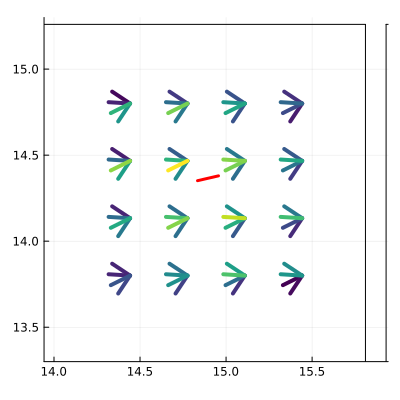

In [28]:
t  = 1

p0  = _ps[t]
x   = stack(polar_inv(_zs[t],_as))

w   = 5
sig = 0.1
dropout = 1e-9

grid_dx  = 0.5
grid_dhd = 90.0
grid_k  = 4

p = perturb(p0, 0.1, 10)
p1, ps, log_p = grid_proposal(p, x, w, sig, dropout, grid_k, grid_dx, grid_dhd);


cs = peak_to_peak(log_p)
# ---------------
mypl = plot(size=(400,400), legend=nothing; yxlims(p.x,1)..., aspect_ratio=:equal)
plot!(_segs, c=:black)
# scatter!([p.x .+ 0.1*[cos(p.hd);sin(p.hd)] for p in ps], zcolor=log_p)
plot!(Pose.(ps), cgrad(:viridis)[cs], r=0.125, linewidth=4)
plot!(p0,c=:red, r=0.125, linewidth=3)
mypl

#### Iterated proposal - gen

In [29]:
#nbx
@gen function iterated_proposal(p::Pose, x::Matrix, 
                                w::Vector{Int}, sig::Vector{Float64}, dropout::Vector{Float64}, 
                                grid_k::Vector{Int}, grid_dx::Vector{Float64}, grid_dhd::Vector{Float64})
    
    n = length(w)
    
    ps = Pose[]
    log_ps = []
    for i=1:n
        args = (p, x, w[i], sig[i], dropout[i], grid_k[i], grid_dx[i], grid_dhd[i])
        p, _, log_p = {  i => :p } ~ grid_proposal(args...)
        push!(ps, p)
        push!(log_ps, log_p)
    end
    return p, ps, log_ps
end;

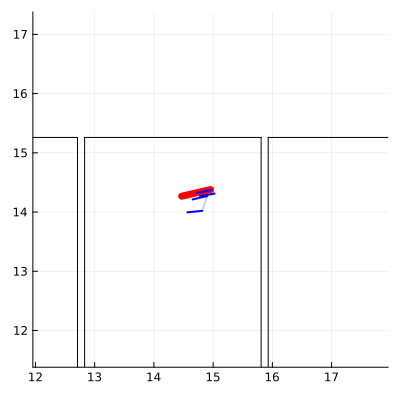

In [30]:
t  = 1

p0  = _ps[t]
x   = stack(polar_inv(_zs[t],_as))

n = 4
w   = fill(10, n)
sig = [0.2, 0.1, 0.1, 0.1]
dropout = fill(1e-9,n)

grid_k   = [4, 4, 4, 4]
grid_dx  = [1., 0.25, 0.125, 0.0625 ]
grid_dhd = [90.0, 45, 22.5, 7]


p = perturb(p0, 0.1, 10)
p, qs, log_qs = iterated_proposal(p, x, w, sig, dropout, grid_k, grid_dx, grid_dhd);


# ---------------
mypl = plot(size=(400,400), legend=nothing; yxlims(p0.x,3)..., aspect_ratio=:equal)
plot!(_segs, c=:black)
plot!(p0,c=:red, r=0.5, linewidth=7)
plot!([q.x for q in qs], c=:blue, linewidth=2, alpha=.2)
plot!(qs, c=:blue, r=0.25, linewidth=2, alpha=1.)
mypl

## SLAM Model

In [31]:
#nbx
include("src/gen_utils.jl")

argdiffs (generic function with 1 method)

General structure:
```julia
motion_model(p::Pose, u::Control, motion_args...)
sensor_model(p::Pose, m::MAP, sensor_args...)
```
Here:
```julia
sensor_model(p::Pose, sensor_args...)
```

```julia

    prior     chain 
     0          1        2          t-1

               u[1] --- u[2]  ...  u[t-1]
                |        |          |
    p[1] - - - p[2] --- p[3]  ...  p[t]
     |          |        |          |
    y[1]       y[2]     y[3]  ...  y[t] 
```

### sensor model

#### sensor_logpf

In [32]:
#nbx
function sensor_logpdf_cu(x::CuArray, y_tilde::CuArray, sig, dropout)
    n = size(y_tilde,1)
    m = size(y_tilde,2)
    
    @assert size(x,1) == size(y_tilde,1)
    
    x = reshape(x, n, 1, 2)
    
    # Compute 1D Gaussians - (n,m,2)
    # Convert to 2D gausians - (n,m)
    # Convert to mixture of m 2D gausians (GM) - (n,)
    # Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # Convert to Product of D's - ()
    log_p = gaussian_logpdf(x, y_tilde, sig)
    log_p = sum(log_p, dims=3)[:,:,1] 
    log_p = logsumexp_cu(log_p .- log(m), 2)[:,1] 
    log_p_or_any_ = log.((1-dropout)*exp.(log_p) .+ dropout*1.0)
    log_p = sum(log_p_or_any_)
    return log_p
end

sensor_logpdf_cu (generic function with 1 method)

#### sensor dist

In [33]:
#nbx
struct SensorDistribution_CUDA <: Distribution{Vector{Vector{Float64}}} 
end

const sensordist_cu = SensorDistribution_CUDA()

function Gen.logpdf(::SensorDistribution_CUDA, x, y_tilde_::CuArray, sig, dropout)
    x_ = CuArray(stack(x))
    return sensor_logpdf_cu(x_, y_tilde_, sig, dropout)
end
function Gen.random(::SensorDistribution_CUDA, y_tilde_::CuArray, sig, dropout)
    n = size(y_tilde_,1)
    m = size(y_tilde_,2)

    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(dropout)
            x_i = [Inf;Inf]
        else
            j = rand(1:m)
            y = Array(y_tilde_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    return x
end

(D::SensorDistribution_CUDA)(args...) = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution_CUDA) = (false, false);

#### sensor model

In [34]:
#nbx
@gen function sensor_model_GPU(p, w, s_noise, dropout)
    p_ = CuArray(Vector(p))
    zs_      = cast_cu(reshape(p_, 1,3))
    y_tilde_ = get_ys_tilde_cu(zs_, w)[1,:,:,:];
    
    x ~ sensordist_cu(y_tilde_, s_noise, dropout)
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing], var"##sensor_model_GPU#1144", Bool[0, 0, 0, 0], false)

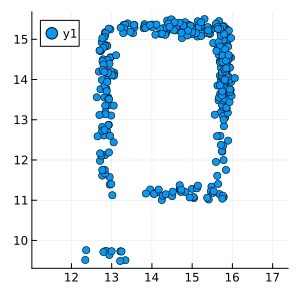

In [35]:
p = _ps[1]
w = 10
s_noise=0.1
dropout=0.1
x = sensor_model_GPU(p, w, s_noise, dropout);
plot(size=(300,300), aspect_ratio=:equal)
scatter!(x.*p)

### static model

In [38]:
#nbx
@gen function slam_kernel(t, state, us, x_noise, hd_noise, w, s_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        x  = {:sensor} ~ sensor_model_GPU(p, w, s_noise, dropout) # GPU accelerated
        
    return (p, x)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [39]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model_GPU(p, w, s_noise, dropout) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), us, 
        x_noise, hd_noise, 
        w, s_noise, dropout)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [40]:
#nbx
get_pose(tr,t)     = tr[][t][1]
get_last_pose(tr)  = tr[][end][1]
get_first_pose(tr) = get_pose(tr,1)

get_x(tr,t)     = tr[][t][2]
get_first_x(tr) = get_x(tr,1)

get_first_x (generic function with 1 method)

### extend

In [43]:
#nbx
function extend(tr, obs, grid_args)

    args  = get_args(tr)    
    diffs = argdiffs([1;fill(0,length(args))])
    t = args[1]    
    x = stack(obs[:chain => t+1 => :sensor => :x])
    
    p = get_last_pose(tr)
    proposal_tr = simulate(iterated_proposal, (p, x, grid_args...));
    proposal_sc = get_score(proposal_tr)
    p′, = proposal_tr[];
    
    
    ch = choicemap()
    ch[:chain => t+1 => :pose => :x]  = p′.x
    ch[:chain => t+1 => :pose => :hd]  = p′.hd
        
    tr′,w′,_,_ = Gen.update(tr,(t+1,args[2:end]...),diffs,merge(obs,ch))
    
    return tr′, w′ - proposal_sc
    
end

extend (generic function with 1 method)

In [44]:
#nbx
function constraints(t::Int)
    ch = choicemap()
    if t==0
        addr  = :sensor => :x
    else
        addr  = :chain => t => :sensor => :x
    end
    n = length(_zs[t+1])
    x = polar_inv(_zs[t+1],_as)
    ch[addr] = x
    return ch
end

constraints (generic function with 1 method)

In [46]:
T = 0

p0 = _ps[1]
x0_noise = .0001
hd0_noise = .00001

x_noise = 0.1
hd_noise = 10.

wind = 30
s_noise = 0.2
dropout = 1e-6

ch = constraints(0)

args = (_us,         
    p0, x0_noise, hd0_noise, # Pose prior model
    x_noise, hd_noise,       # Motion model
    wind, s_noise, dropout   # Sensor model
)

@time tr, w = generate(static_slam_model, (T,args...), ch);

  0.001507 seconds (1.25 k allocations: 76.625 KiB)


In [47]:
for T=1:10

    x   = stack(polar_inv(_zs[T+1],_as))

    n = 5
    w   = fill(60, n)
    sig = fill(0.2,n)
    dropout = fill(1e-9,n)

    grid_k   = [4, 4, 4, 4, 4]
    grid_dx  = [1., 0.4, 0.125, 0.125, 0.125]
    grid_dhd = [90.0, 45, 22.5, 10, 10]

    grid_args = (w, sig, dropout, grid_k, grid_dx, grid_dhd)


    ch = constraints(T)

    tr, dw = extend(tr, ch, grid_args);
end

In [106]:
# p0 = _ps[1]
# x0_noise = .0001
# hd0_noise = .00001

# x_noise  = 0.5
# hd_noise = 20.

# wind = 30
# s_noise = 0.2
# dropout = 1e-6

# args = (_us,         
#     p0, x0_noise, hd0_noise, # Pose prior model
#     x_noise, hd_noise,       # Motion model
#     wind, s_noise, dropout   # Sensor model
# );

### naive posterior

In [48]:
function naive_posterior(T, N, args)

    ch = choicemap()
    for t=0:T
        ch = merge(ch, constraints(t))
    end
    
    trs, ws, = importance_sampling(static_slam_model, (T,args...), ch, N);
    
    probs = exp.(ws .- logsumexp_cu(ws, 1))
    i = categorical(probs)
    tr = trs[i]
    w  = ws[i]
    
    tr, w
end

naive_posterior (generic function with 1 method)

### Simple Particle filter

In [49]:
function simple_posterior(T, N, args)
    ch = constraints(0)
    tr, w = generate(static_slam_model, (0,args...), ch);
    
    trs = fill(tr, N)
    ws  = fill(w,N)
    
    diffs = argdiffs([1;fill(0,length(args))])
    for t=1:T
        ch = constraints(t)        
        for i=1:N
            tr, dw, _, _ = Gen.update(trs[i], (t,args...), diffs, ch); 
            trs[i] = tr
            ws[i] += dw 
        end
        probs = exp.(ws .- logsumexp_cu(ws, 1))
#         i = argmax(probs)
#         inds = Distributions.rand(Distributions.Categorical(probs), (N,))
#         trs = trs[inds]
#         ws = zeros(N)
    end
    
    probs = exp.(ws .- logsumexp_cu(ws, 1))
    i = categorical(probs)
#     i = argmax(probs)
    tr = trs[i]
    w  = ws[i]
    tr, w
end

simple_posterior (generic function with 1 method)

### SMC posterior

In [50]:
function smc_posterior(T, args, grid_args)


    ch = constraints(0)
        
    tr, w = generate(static_slam_model, (0,args...), ch);
    for t=1:T

        x   = stack(polar_inv(_zs[t+1],_as))
        ch = constraints(t)
        
        # Similar to "SimpleExtendingTraceTranslator"
        # Grid "search" happens within that func
        tr, dw = extend(tr, ch, grid_args);
        w = w + dw
    end
    return tr, w
end

smc_posterior (generic function with 1 method)

## Ani

In [51]:
function perturb(us::Vector{Tuple{Vector{Float64}, Float64}}, x_noise=0.1, hd_noise=10.0)
   us_tilde = [(
            u[1]+diagnormal([0;0],[x_noise;x_noise]),
            u[2]+normal(0,hd_noise/360*2π))
        for u in us
    ]
    return us_tilde
end

perturb (generic function with 4 methods)

In [52]:
p0 = _ps[1]
x0_noise  = .0001
hd0_noise = .0001

# Motion/Control noise
x_noise  = 0.25
hd_noise = 10.

# Sensor args
wind    = 10
s_noise = 0.1
dropout = 1e-8

args = (
    _us,         
    p0, x0_noise, hd0_noise, # Pose prior model
    x_noise, hd_noise,       # Motion model
    wind, s_noise, dropout   # Sensor model
);

get_model_args(x_noise, hd_noise, wind, s_noise) = (
    perturb(_us, x_noise, hd_noise),         
    p0, x0_noise, hd0_noise, # Pose prior model
    x_noise, hd_noise,       # Motion model
    wind, s_noise, dropout   # Sensor model
);

In [53]:
n   = 5
w   = fill(20, n)
sig = fill(0.1,n)
fill(dropout,n)

grid_k   = [4, 4, 4, 4, 4]
grid_dx  = [1., 0.4, 0.125, 0.125, 0.125]
grid_dhd = [90.0, 45, 22.5, 10, 10]

grid_args = (w, sig, dropout, grid_k, grid_dx, grid_dhd);

get_grid_args(n, k, w,sig) = (
    fill(w, n), 
    fill(sig, n), 
    fill(1e-9,n), 
    fill(k, n), 
    collect(range(1.0, 0.125, n)),
    collect(range(90.0, 10., n))
);

In [54]:
args = get_model_args(0.1, 5.0, 10, 0.2)
grid_args = get_grid_args(4, 4, 10, 0.2)

naive_posterior(1, 10, args);
simple_posterior(1, 10, args);
smc_posterior(1, args, grid_args);

In [55]:
using Interact


WebIO._IJuliaInit()

## Interact

In [56]:
function plot_it(
        posterior, show_u, show_x,
        n,T,N, 
        x_noise, hd_noise, 
        mix_w, s_noise, 
        grid_n, grid_k, grid_w, grid_s_noise
        )
    args = get_model_args(x_noise, hd_noise, mix_w, s_noise);
    grid_args = get_grid_args(grid_n, grid_k, grid_w, grid_s_noise);
    
    trs = []
    for i=1:n
        print(i)
        if posterior == :naive
            tr,w = naive_posterior(T, N, args)
        elseif posterior == :pf
            tr,w = simple_posterior(T, N, args)
        elseif posterior == :smc
            tr,w = smc_posterior(T, args, grid_args)
        end
        push!(trs,tr)
    end
    
    

    ani = Animation()
    for i=1:length(trs)
        
        mypl = plot(
            size=(500,500), legend=nothing, 
            title="$(posterior)\nσₓ = $(x_noise)\nσᵣ = $(hd_noise)"; 
            xlim=(4,17),
            ylim=(8,19),
            aspect_ratio=:equal)

        plot!(_segs, c=:black, linewidth=2)

        if show_x
            tt = T
            x_true = polar_inv(_zs[tt],_as)
            scatter!(x_true.*_ps[tt], c=:red, markersize=2, markerstrokewidth=0, alpha=0.5 )
        end
        
        n=14
        ss = range(0,0.9,n)
        for j=1:n

            s= ss[j]
            i_ = mod(i+j-1,length(trs))+1
            tr = trs[i_]

            ps = [r[1] for r in tr[]];
            xs = [r[2] for r in tr[]];

            c = :lightgray
            plot!([p.x for p in ps], c=c, linewidth=1, alpha=range(0,0.8,n)[j] )
            plot!(ps, c=c, r=0.25, linewidth=2, alpha=range(0,1.,n)[j] )
        end


        plot!(_ps[1:T+1],c=:black, r=0.5, linewidth=2)
        
        if show_x
            tt = T
            plot!([_ps[tt]],c=:red, r=0.5, linewidth=3)
        end
        
        if show_u
            pus = [Pose(p.x+u[1],p.hd+u[2]) for (p,u) in zip(_ps[2:end],args[1])]
            for tt in 1:T
                plot!([_ps[1+tt].x,pus[tt].x],c=:green, r=0.25, linewidth=2, alpha=0.5)
            end
            plot!(pus[1:T],c=:green, r=0.25, linewidth=2)
        end


        frame(ani, mypl)
    end
    
    gif(ani, fps=15)
end

plot_it (generic function with 1 method)

In [66]:
1

In [64]:
n = slider(1:20:60, value=1, label="# samples")
T = slider(5:20, value=5, label="T")
N = slider(1:50:250, value=1, label="# particles")
show_u = toggle(label = "show u", value=false)
show_x = toggle(label = "show obs", value=false)
posterior = togglebuttons([:naive, :pf, :smc])

x_noise  = slider(range(0.001,0.5,5), label="n=x_noise")
hd_noise = slider(range(0.001,45.,5), label="hd_noise")
mix_w    = slider( 1:5:50, label="mixture size")
s_noise  = slider(range(0.01,1.0,10), label="s_noise")

grid_n = slider(1:10,label="grid iters")
grid_k = slider(2:10,label="grid shape")
grid_w = slider(1:5:50,label="grid mixture size")
grid_s_noise = slider(range(0.01,1.0,10),label="grid s_noise")

sample = button("Sample")

plt = Interact.@map (&sample;  plot_it(
        posterior[], show_u[], show_x[],
        n[],T[],N[], 
        x_noise[], hd_noise[], 
        mix_w[], s_noise[], 
        grid_n[], grid_k[], grid_w[], grid_s_noise[]
        )
)

vbox(
    sample,
    hbox(posterior),
    hbox(show_u, show_x),
    hbox(n,T,N),
    hbox(x_noise, hd_noise, mix_w, s_noise),
    hbox(grid_n, grid_k,grid_w,grid_s_noise),
    plt
)

In [141]:
ani = Animation()
frames=[]



@manipulate for n=slider(1:20:60, value=1, label="n"),
                T=5:20,
                N=slider(1:50:250, value=1, label="N"),
                show_u=[false, true],
                show_x=[false, true],
                which_x_n=1:10,
                which_x_t=1:20,
                posterior=[:naive, :pf, :smc],
                x_noise  = range(0.001,0.5,5),
                hd_noise = range(0.001,45.,5),
                mix_w   = 1:5:50,
                s_noise = range(0.01,1.0,10),
                grid_n=1:10,
                grid_k=2:10,
                grid_w=1:5:50,
                grid_s_noise=range(0.01,1.0,10)
    
    args = get_model_args(x_noise, hd_noise, mix_w, s_noise);
    grid_args = get_grid_args(grid_n, grid_k, grid_w, grid_s_noise);
    
    trs = []
    for i=1:n
        print(i)
        if posterior == :naive
            tr,w = naive_posterior(T, N, args)
        elseif posterior == :pf
            tr,w = simple_posterior(T, N, args)
        elseif posterior == :smc
            tr,w = smc_posterior(T, args, grid_args)
        end
        push!(trs,tr)
    end

    mypl = plot(size=(500,500), legend=nothing; 
        xlim=(4,17),
        ylim=(8,19),
        aspect_ratio=:equal)
    
ani_new = Animation()
println()
n=14
for i=1:length(trs)
# for i=1:1
    print(i)
    mypl = plot(size=(500,500), legend=nothing, title="$(posterior)\nσₓ = $(x_noise)\nσᵣ = $(hd_noise)"; 
        xlim=(4,17),
        ylim=(8,19),
        aspect_ratio=:equal)
    
    plot!(_segs, c=:black, linewidth=2)


    
    if show_x
            tt = which_x_t
            nn = which_x_n
       x_true = polar_inv(_zs[tt],_as)
        scatter!(x_true.*_ps[tt], c=:red, markersize=2, markerstrokewidth=0, alpha=0.5 )
    end
    ss = range(0,0.9,n)
    for j=1:n

        s= ss[j]
        i_ = mod(i+j-1,length(trs))+1
        tr = trs[i_]

        ps = [r[1] for r in tr[]];
        xs = [r[2] for r in tr[]];
        
        c = :lightgray
            
#         for l=1:30:360
#         for (a,b) in zip(x_true,xs[end])
#                 plot!([x_true[l]*_ps[T],xs[end][l]*ps[end]], c=:red, alpha=range(0,0.2,n)[j])
#         end
#             scatter!(xs[end].*ps[end], c=col[1], markersize=1, markerstrokewidth=0, alpha=range(0,0.2,n)[j] )
#         scatter!(xs[end].*ps[end], c=col[1], markersize=3, markerstrokewidth=0, alpha=range(0,0.2,n)[j] )
            
        plot!([p.x for p in ps], c=c, linewidth=1, alpha=range(0,0.8,n)[j] )
        plot!(ps, c=c, r=0.25, linewidth=2, alpha=range(0,1.,n)[j] )
    end
    

    
    plot!(_ps[1:T+1],c=:black, r=0.5, linewidth=2)
    if show_x
            tt = which_x_t
            nn = which_x_n

        plot!([_ps[tt]],c=:red, r=0.5, linewidth=3)
    end
    if show_u
            pus = [Pose(p.x+u[1],p.hd+u[2]) for (p,u) in zip(_ps[2:end],args[1])]
        
        for tt in 1:T
            plot!([_ps[1+tt].x,pus[tt].x],c=:green, r=0.25, linewidth=2, alpha=0.5)
        end
        plot!(pus[1:T],c=:green, r=0.25, linewidth=2)
    end
        
    
    frame(ani_new, mypl)
        mypl
    
end
#     mypl
    ani = ani_new
    gif(ani, "_gifs/_vkm_2/loc_$(posterior).gif", fps=15)
end

1
1

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/_gifs/_vkm_2/loc_naive.gif


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 3, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/ubuntu/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/ubuntu/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/ubuntu/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/home/ubuntu/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/home/ubuntu/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f5c897e85d0, Task (runnable) @0x00007f5c897e85d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"21\",\"41\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"16385328324342212876\",\"id\":\"6134814117290500317\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"16385328324342212876\",\"id\":\"12004230819449100993\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel

1
1

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/_gifs/_vkm_2/loc_pf.gif


1
1

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/_gifs/_vkm_2/loc_pf.gif


123456789101112131415161718192021
123456789101112131415161718192021

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/_gifs/_vkm_2/loc_pf.gif


123456789101112131415161718192021
123456789101112131415161718192021

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/_gifs/_vkm_2/loc_smc.gif


In [ ]:
x = 0.5


function func(args...)
    global x
    x += π/4
end
update = button("Sample")


In [ ]:
@manipulate for f = [sin, cos], both = false

end

In [676]:
T = 17
trs= []
ws = []
for i=1:50
    print(i, "-")
    N = 10
    tr,w = naive_posterior(T, N, args)
#     tr,w = simple_posterior(T, N, args)
#     tr,w = smc_posterior(T, args, grid_args)
    push!(trs,tr)
    push!(ws,w)
end

1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-

1-

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/tmp.gif")
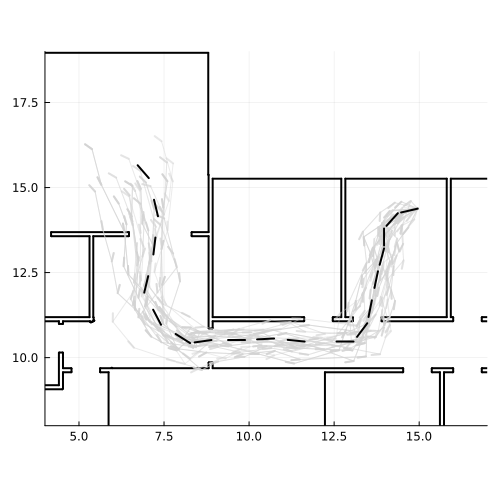

In [675]:
T = length(trs[1][])
ani = Animation()
n = 40
# for i=1:length(trs)
for i=1:1
    print(i, "-")
    mypl = plot(size=(500,500), legend=nothing; 
        xlim=(4,17),
        ylim=(8,19),
        aspect_ratio=:equal)
    
    plot!(_segs, c=:black, linewidth=2)



    
    ss = range(0,0.9,n)
    for j=1:n

        s= ss[j]
        i_ = mod(i+j-1,length(trs))+1
        tr = trs[i_]
#     for (s,tr) in zip(range(0,1,n),trs[i:i+n])
        ps = [r[1] for r in tr[]];
        xs = [r[2] for r in tr[]];
        
        c = :lightgray
#         scatter!(xs[end].*ps[end], c=col[1], markersize=3, markerstrokewidth=0, alpha=range(0,0.2,n)[j] )
        plot!([p.x for p in ps], c=c, linewidth=1, alpha=range(0,0.8,n)[j] )
        plot!(ps, c=c, r=0.25, linewidth=2, alpha=range(0,1.,n)[j] )
    end
    
#     plot!(_ps[1:T],c=:red, r=0.5, linewidth=2)
    
    plot!(_ps[1:T],c=:black, r=0.5, linewidth=2)
    
    frame(ani, mypl)
    
end;

gif(ani,fps=15)

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/gifs/smc.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/gifs/smc.gif")
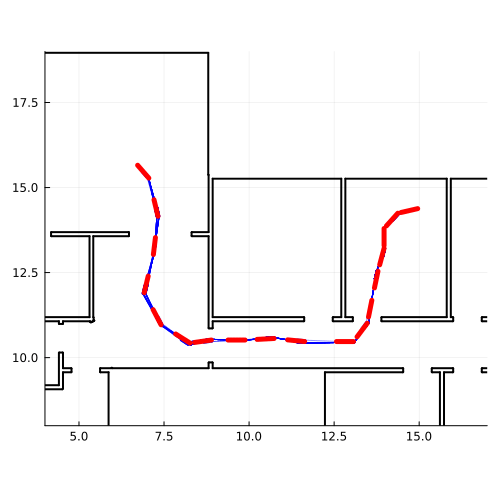

In [595]:
gif(ani, "gifs/smc.gif", fps=15)